# Setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LN

# Question 1

## Apply Hough Transform

In [2]:
img = cv.imread('coins_1.jfif')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (7, 7), 1.5)

row = img.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, row/8, param1 = 150, 
                         param2 = 25)

if circles is not None:
    circles = np.uint8(np.around(circles))
    for i in circles[0]:
        # draw the center of the circle
        center = (i[0], i[1])
        cv.circle(img, center, 1, (100, 100, 100), 3)
        # draw the whole circle
        radius = i[2]
        cv.circle(img, center, radius, (255, 0, 0), 3)

## Apply Blob Detection

In [3]:
img1 = cv.imread('coins_1.jfif')
blur = cv.medianBlur(img1, 5)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# parameter setting
params = cv.SimpleBlobDetector_Params()

# turn off the filter
params.filterByArea = True
params.minArea = 800
params.filterByColor = True
params.blobColor = 255
params.filterByConvexity = False
params.filterByInertia = False

# detector
detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)

# draw
im_keypoints = cv.drawKeypoints(img1, keypoints, np.array([]), (0, 0, 255), 
                               cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display both output

In [4]:
cv.imshow('result', np.hstack((img, im_keypoints)))
cv.waitKey(0)
cv.destroyAllWindows()

Hough Transform produce an output of bigger edge is drawn on the coins. The center of object is also plotted at the coins itself.

Blob Detection produce a clearer output of object detection. More configuration need to be done on blob detection compared to hough transform. In this case, blob detection is also more flexible compared to hough transform.

# Question 2

In [5]:
# 2 helper functions

def centroid_histogram(clust_labels):
    # Create histogram based on the number of pixels assigned to each cluster
    numLabels = len(np.unique(clust_labels))
    hist, _ = np.histogram(clust_labels, bins = numLabels)
    
    # Normalize the histogram, such that it sums to one
    hist = hist.astype("float32")
    hist /= hist.sum()
    
    return hist

def plot_colors(hist, centroids):
    # Initialize bar chart representing relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = np.uint8)
    startX = 0
    
    # loop over the percentage of each cluster and the color of each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent*300)
        cv.rectangle(bar, (int(startX), 0), (int(endX), 50),
                    color.astype("uint8").tolist(), -1)
        startX = endX
        
    # return bar chart
    return bar

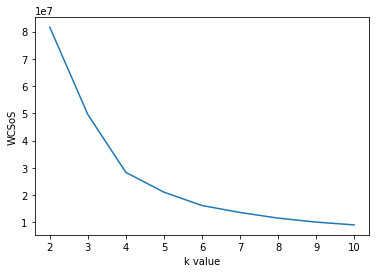

In [6]:
# k-means clustering on images

img = cv.imread('zebra.jfif')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#1: reshape the image
img_reshape = img_rgb.reshape((-1, 3))
img_reshape = np.float32(img_reshape)

# Array to store k and WCSoS values 
k_array = np.array([])
WCSoS_array = np.array([])

#2: define criteria, attempts and test out the k value
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10

for k in range (2,11):
    ret, label, center = cv.kmeans(img_reshape, k, None, criteria, attempts, 
                               cv.KMEANS_PP_CENTERS)
    k_array = np.append(k_array, k)
    WCSoS_array = np.append(WCSoS_array, ret)

# plot the graph
plt.plot(k_array, WCSoS_array)
plt.xlabel('k value'), plt.ylabel('WCSoS')
plt.show()

Clear albow at k = 4, Optimal k = 4

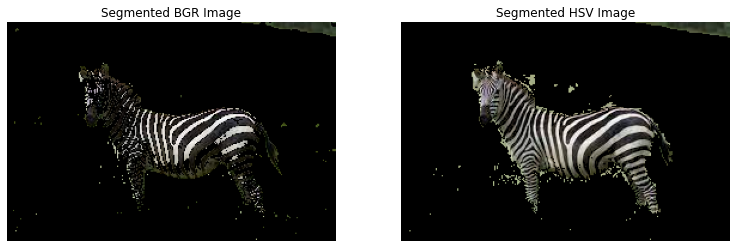

In [7]:
# Create bgr and hsv image

img = cv.imread('zebra.jfif')
img_bgr = img.copy()
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Image reshape
img_bgr_reshape = img_bgr.reshape((-1, 3))
img_bgr_reshape = np.float32(img_bgr_reshape)

img_hsv_reshape = img_hsv.reshape((-1, 3))
img_hsv_reshape = np.float32(img_hsv_reshape)

# Define criteria, k, attempts for both images
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 4
attempts = 10

ret, label, center = cv.kmeans(img_bgr_reshape, k, None, criteria, attempts, 
                               cv.KMEANS_PP_CENTERS)

ret2, label2, center2 = cv.kmeans(img_hsv_reshape, k, None, criteria, attempts, 
                               cv.KMEANS_PP_CENTERS)

# convert center to np.uint8
center = np.uint8(center)
res = center[label.flatten()]
res_seg = res.reshape((img_bgr.shape))

center2 = np.uint8(center2)
res2 = center2[label2.flatten()]
res_seg2 = res2.reshape((img_hsv.shape))

# Define white and black for bgr
white_color = (255, 255, 255)
black_color = (0, 0, 0)

white = np.argmin(LN.norm(white_color - center, axis = 1))
white_mask = res_seg == center[white]
seg_img_white = img_bgr*(white_mask.astype("uint8"))

black = np.argmin(LN.norm(black_color - center, axis = 1))
black_mask = res_seg == center[black]
seg_img_black = img_bgr*(black_mask.astype("uint8"))

seg_img_bgr = cv.bitwise_or(seg_img_white,seg_img_black, mask = None)

# Define white and black for hsv
white_color_hsv = (0, 0, 255)
black_color_hsv = (0, 0, 0)

white_hsv = np.argmin(LN.norm(white_color_hsv - center2, axis = 1))
white_mask2 = res_seg2 == center2[white_hsv]
seg_img2_white = img_hsv*(white_mask2.astype("uint8"))

black_hsv = np.argmin(LN.norm(black_color_hsv - center2, axis = 1))
black_mask2 = res_seg2 == center2[black_hsv]
seg_img2_black = img_hsv*(black_mask2.astype("uint8"))

seg_img_hsv = cv.bitwise_or(seg_img2_white,seg_img2_black, mask = None)

# Display output
plt.figure(figsize = (20,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(seg_img_bgr, cv.COLOR_BGR2RGB))
plt.title('Segmented BGR Image'), plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(seg_img_hsv, cv.COLOR_HSV2RGB))
plt.title('Segmented HSV Image'), plt.axis("off")
plt.show()

More part of zebra is segmented when we are using HSV color space.